# BE/Bi 103, Fall 2015: Homework 8
## Due 1pm, Monday, December 9

*This document was generated from a Jupyter notebook.  You can download the notebook [here](hw8.ipynb).*

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler



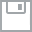
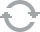
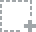
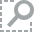
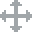
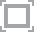
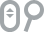
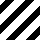
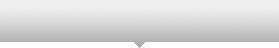
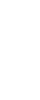
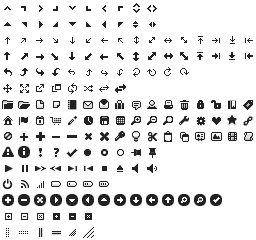
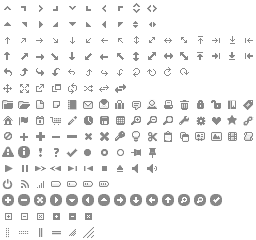
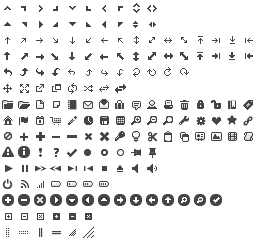
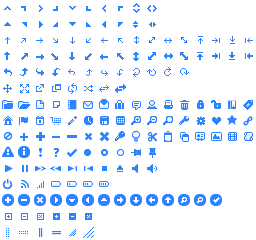
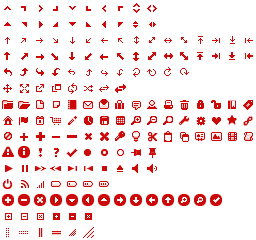
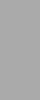
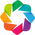
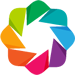

In [39]:
import os
import pickle
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.ndimage
import scipy.optimize
import scipy.signal
import scipy.stats as st

# Image processing tools
import skimage
import skimage.io
import skimage.feature
import skimage.filters
import skimage.morphology
import skimage.segmentation

# BE/Bi 103 utilities
import bebi103

# To assess where the bottlenecks are
%load_ext line_profiler

# Do JIT for speed
import numba

# Numdifftools for Hessian calculations
import numdifftools as ndt

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.io
import bokeh.models
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem 8.1: Caulobacter growth, 95 pts

In this problem, we will study the growth and division of *Caulobacter crescentus* over time.  The lab of [Norbert Scherer](http://schererlab.uchicago.edu) at the University of Chicago acquired these data and recently published the work in PNAS, which you can download [here](http://bebi103.caltech.edu/2015/protected/papers/iyer-biswas_2014.pdf).

The clever experimental set-up allows imaging of single dividing cells in conditions that are identical through time.  This is accomplished by taking advantage of a unique morphological feature of *Caulobacter*.  The mother cell is adherent to the a surface through its stalk.  Upon division, one of the daughter cells does not have a stalk and is mobile.  The system is part of a microfluidic device that gives a constant flow.  So, every time a mother cell divides, the un-stalked daughter cell gets washed away.  In such a way, the dividing cells are never in a crowded environment and the buffer is always fresh.  This also allows for easier segmentation.

The data were sent to you via Dropbox.  They were kindly provided by Charlie Wright in the Scherer lab.  The frame rate is 1 frame per minute.  The interpixel spacing is 0.052 µm.  All images were acquired at 24 $^\circ$C.

As with any of the problems in this class, you are encouraged to explore the data beyond what is asked for specifically in the problems statements.  The paper is also a very interesting read.

**a)** The directory `sequential_full_field` contains 10 sequential frames of a full field of bacteria in the microfluidic device.  From these frames, choose which bacteria would be good to use to gather long time course imaging.  I.e., choose those that you think will give minimal errors in segmentation.  Give your reasoning, including images demonstrating segmentation.

**b)** The files `bacterium_1.tif` and `bacterium_2.tif` are TIFF stacks of time courses for specific cells in from the full field images.  From these time courses, compute the time scale of division of the cells.  In other words, compute the time between divisions for each division for each cell and plot the results.  Comment on any interesting aspects of these data.

**c)** In their paper, the authors argue that the growth rate of the cell is exponential.  I.e.,

\begin{align}
a(t) = a_0 \mathrm{e}^{\kappa t},
\end{align}

where $a(t)$ is the area of the cell in the image as a function of time and $a_0$ is the area of the cell right after a division has been completed, which we mark as $t = 0$.

As an alternative model, the authors consider a linear growth model, in which

\begin{align}
a(t) = a_0 + b t.
\end{align}

An exponential curve is approximately linear (with $b = a_0\kappa$) for short time scales.  So, it is often difficult to distinguish between a linear and an exponential growth rate.  Use the model selection methods we learned in class to assess the relative probabilities that the growth rate is exponential versus linear.

### Problem 8.1: Solution
**a)** To be completed.

**b)** Our strategy to find division events is this:

1. Use simple thresholding to segment the image into bacteria and not bacteria.
2. Clear the borders for bacteria that are not of central interest.
3. Label the image and compute region props.
4. Take the area of the largest object as the area of the bacterium of interest.  These constitute the time series data of area vs. time.
5. Delete areas that are obvious segementation areas where the area is unreasonably large or small.  In this case, we take the lower bound on bacterial size to be 1 µm and the upper bound to be 3.5 µm.
6. Perform a median filter on the remaining area vs. time data.  This eliminates one-off outliers.
7. Find the time points where the median filtered trace has a down-crossing of a threshold.  This threshold is larger than the size of the mother bacterium, in our case, 2 µm.
8. Only downcrossings followed by ten minutes of growth are allowed.  This is a further check to make sure an outlier did not affect the division point.

We start by writing a function to compute the area of the bacteria in the image using thresholding.

In [2]:
def area_thresh(im, interpixel_distance):
    """
    Threshold an image and return the area of the largest object.
    """
    # Threshold image
    im_bw = im < skimage.filters.threshold_otsu(im)
    
    # Clear borders
    im_bw = skimage.segmentation.clear_border(im_bw)
    
    # Label binary image
    im_labeled = skimage.measure.label(im_bw, background=0, return_num=False)
    
    # Find areas of all objects
    im_props = skimage.measure.regionprops(im_labeled + 1)

    # Find largest area
    max_area = 0
    for prop in im_props:
        if prop.area > max_area:
            max_area = prop.area

    return max_area * interpixel_distance**2

We'll now write a function to generate the area vs. time curve as well as the indices where division occurs.

In [3]:
def areas_divisions(t, ic, interpixel_distance, div_thresh, n_below, abs_thresh,
                    median_kernel_size):
    """
    Compute areas of mother bacterium over time
    """
    # Compute the bacterial area for each image
    areas = np.empty(len(ic))
    for i, im in enumerate(ic):
        areas[i] = area_thresh(im, interpixel_distance)
        
    # Determine which points are good
    good_inds = (areas > abs_thresh[0]) & (areas < abs_thresh[1])
    
    # Slice out good data points
    t = t[good_inds]
    areas = areas[good_inds]

    # Perform median filter to eliminate outliers
    areas_filt = scipy.signal.medfilt(areas, kernel_size=median_kernel_size)

    # Get downcrossings
    down_inds = np.where((areas_filt[:-1] > div_thresh) 
                        & (areas_filt[1:] < div_thresh))[0] + 1

    # Filter out spurious downcrossings
    div_inds = [i for i in down_inds 
                        if np.all(areas_filt[i:i+n_below] < div_thresh)]
    
    return t, areas, div_inds

Now we can proceed with our analysis for the first bacterium.  We will use a kernel size of 9 time points for our median kernel.

In [4]:
# Images and metadata
data_dir = '../data/iyer-biswas_et_al/hw8_iyer-biswas_et_al'
fname = os.path.join(data_dir, 'bacterium_1.tif')
interpixel_distance = 0.052  # µm
dt = 1 # minutes

# Threshold for division
div_thresh = 2  # µm^2

# Absolute thresholds for big and small cells
abs_thresh = (1, 3.5) # µm^2

# Number of time points below threshold to be considered divided
n_below = 10

# Size of median filter kernel
median_kernel_size = 9

# Load images
ic = skimage.io.ImageCollection(fname)[0]

# Determine time points
t_1 = np.arange(len(ic)) / dt

# Get area/time curve with division points
t_1, areas_1, div_inds_1 = areas_divisions(
        t_1, ic, interpixel_distance, div_thresh, n_below, abs_thresh, 
        median_kernel_size)

Now we can plot the cell areas and division events.  Note that even though we used the median filtered time series to find division events, we plot the unfiltered areas.

In [5]:
# Set up the figure (this is like a canvas you will paint on)
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=250)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'time(s)'
p.yaxis.axis_label = 'cell area (sq µm)'

# Specify the glyphs
p.circle(t_1, areas_1, size=3)
for di in div_inds_1:
    p.ray(x=t_1[di], y=0, length=0, angle=90, angle_units='deg',
          color='tomato', line_width=2)
    p.ray(x=t_1[di], y=0, length=0, angle=-90, angle_units='deg',
          color='tomato', line_width=2)

bokeh.io.show(p)

Our analysis looks pretty good.  Even though we had some outliers, we still got the division points right.  Note that in come cases, the cell area goes down before the precipitous drop.  This could be due to a cell being almost pinched off and coming in and out of the focal plane, leading to errors in segmentation.

We can repeat the analysis for the other bacterium.

In [6]:
# Images and metadata
fname = os.path.join(data_dir, 'bacterium_2.tif')

# Load images
ic = skimage.io.ImageCollection(fname)[0]

# Determine time points
t_2 = np.arange(len(ic)) / dt

# Do the calculation
t_2, areas_2, div_inds_2 = areas_divisions(
        t_2, ic, interpixel_distance, div_thresh, n_below, abs_thresh, 
        median_kernel_size)

We'll plot the time trace for this one as well.

In [7]:
# Set up the figure (this is like a canvas you will paint on)
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=250)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'time(s)'
p.yaxis.axis_label = 'cell area (sq µm)'

# Specify the glyphs
p.circle(t_2, areas_2, size=3)
for di in div_inds_2:
    p.ray(x=t_2[di], y=0, length=0, angle=90, angle_units='deg',
          color='tomato', line_width=2)
    p.ray(x=t_2[di], y=0, length=0, angle=-90, angle_units='deg',
          color='tomato', line_width=2)

bokeh.io.show(p)

It is hard to see without zooming, but you can scroll around the plot and see that we identified all of the division points.

Now, let's look at the distributions of division times for each bacterium.

/Users/Justin/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


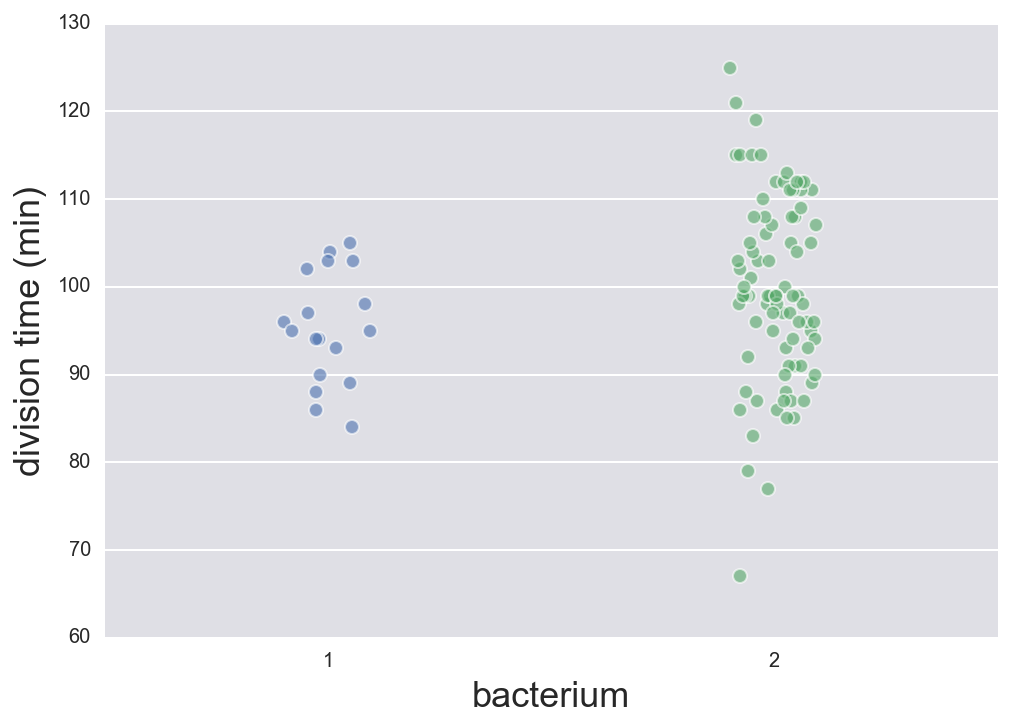

In [8]:
# Set up DataFrame with results
df = pd.DataFrame(columns=['bacterium', 'division time (min)'])
div_times_1 = np.diff(div_inds_1) * dt
div_times_2 = np.diff(div_inds_2) * dt
df['bacterium'] = np.concatenate((np.ones_like(div_times_1), 
                                  np.ones_like(div_times_2) * 2))
df['division time (min)'] = np.concatenate((div_times_1, div_times_2))

sns.stripplot(x='bacterium', y='division time (min)', data=df, jitter=True, 
              alpha=0.6)

The division times between the two seem to be similarly distributed, perhaps with bacterium 2 being more broadly distributed.  We have many more samples for bacterium 2, so we can say more about its distribution.  In particular, we can do a KDE and plot the result.


Division time = 99.7 ± 10.6 min



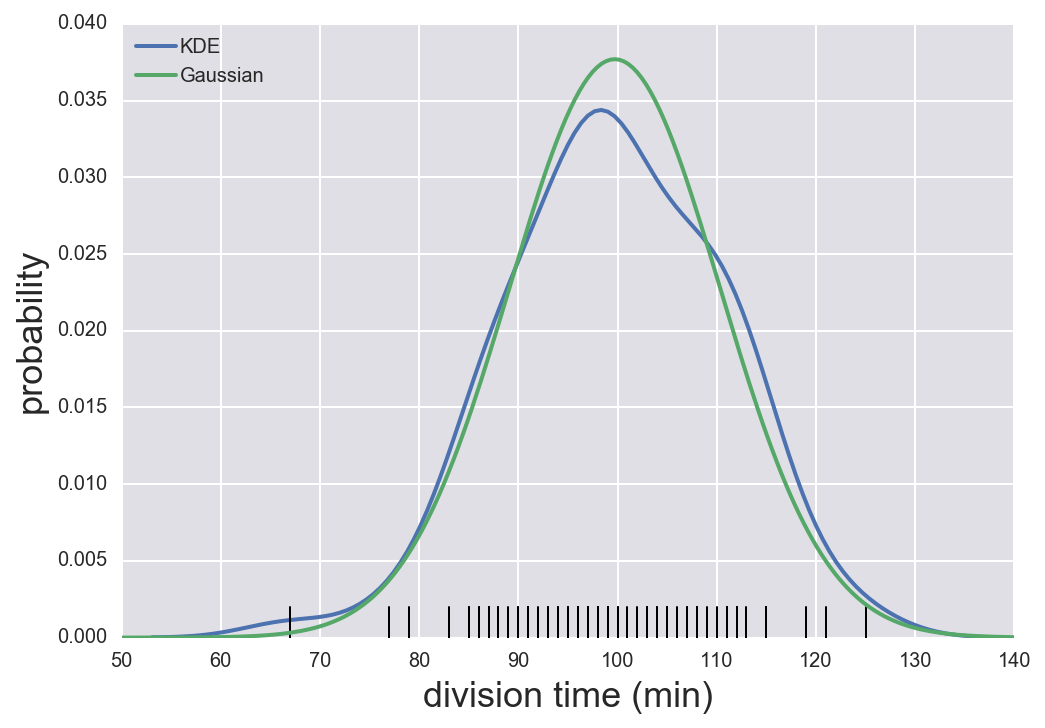

In [9]:
# Make KDE plot
_ = sns.kdeplot(div_times_2, kernel='gau', bw='Scott', label='KDE')
_ = sns.rugplot(div_times_2)

# Make plot of Gaussian with same mean and variance
t_plot = np.linspace(50, 140, 200)
p_gauss = st.norm.pdf(t_plot, div_times_2.mean(), div_times_2.std())
plt.plot(t_plot, p_gauss, label='Gaussian')

# Clean up
plt.xlabel('division time (min)')
plt.ylabel('probability')
plt.legend(loc='upper left')

# Print mean and standard deviation
print("""
Division time = {0:.1f} ± {1:.1f} min
""".format(div_times_2.mean(), div_times_2.std()))

So, the division times are approximately Gaussian distributed with a mean of about 100 minutes and a standard deviation of about 10 minutes.

**c)** To perform the paremeter estimation and model selection, we will use PTMCMC using a hierarchical model.  For bacterium $i$, the growth curve before division event $j$ is described by

\begin{align}
\text{area}^\mathrm{theor}_{ij}(t) = a_{ij} + b_{ij} t
\end{align}

for a linear model and

\begin{align}
\text{area}^\mathrm{theor}_{ij}(t) = a_{ij}\mathrm{e}^{\kappa t}
\end{align}

for an exponential model.  For simplicity in this theoretical treatment, we will consider the linear model, but the analysis is identical for the exponential model; just swap $b$'s for $\kappa$'s in what follows.

Bacterium $i$ has a characteristic growth rate $b_i$ and area immediately after division $a_i$.  *Caulobacter* in general have a characteristic growth rate $b$  and area $a$ under the conditions of this experiment.  We assume the growth rate for given *Caulobacter* cells is Gaussian distributed with variance $\sigma_b^2$, and we assume further that the growth rate between a given pair of sequential division events for mother cell $i$ is also Gaussian distributed with mean $b_i$ and variance $\sigma_{ai}^2$.  We similarly define $\sigma_{a}$ and $\sigma_{ai}$.  Thus, we have

\begin{align}
P(b_i\mid b, \sigma, I) &= \frac{1}{\sqrt{2\pi \sigma_b^2}}\,\mathrm{e}^{-(b_i-b)^2/2\sigma^2},\\[1em]
P(a_i\mid a, \sigma, I) &= \frac{1}{\sqrt{2\pi \sigma_a^2}}\,\mathrm{e}^{-(a_i-a)^2/2\sigma^2},
\end{align}

and

\begin{align}
P(b_{ij}\mid b_i, \sigma_{bi}, I) &= \frac{1}{\sqrt{2\pi \sigma_{bi}^2}}\,\mathrm{e}^{-(b_{ij}-b_i)^2/2\sigma_{bi}^2}, \\[1em]
P(a_{ij}\mid a_i, \sigma_{ai}, I) &= \frac{1}{\sqrt{2\pi \sigma_{ai}^2}}\,\mathrm{e}^{-(a_{ij}-a_i)^2/2\sigma_{ai}^2}.
\end{align}

For ease of notation, we denote the set of $a_{ij}$ as $\mathsf{A}$, the set of $b_{ij}$ as $\mathsf{B}$, the set of $b_i$ as $\mathbf{b}$, the set of $\sigma_{bi}$ as $\boldsymbol{\sigma}_b$, and the set of $\sigma_{ai}$ as $\boldsymbol{\sigma}_a$. We can then write the above portions of the prior as

\begin{align}
P(\mathbf{b}\mid b, \sigma_b, I) &= \prod_i \frac{1}{\sqrt{2\pi \sigma_b^2}}\,\mathrm{e}^{-(b_i-b)^2/2\sigma_b^2},\\[1em]
P(\mathbf{a}\mid a, \sigma_a, I) &= \prod_i \frac{1}{\sqrt{2\pi \sigma_a^2}}\,\mathrm{e}^{-(a_i-a)^2/2\sigma_a^2},
\end{align}

and

\begin{align}
P(\mathsf{B}\mid \mathbf{b}, \boldsymbol{\sigma}_b, I) &= \prod_i\prod_j \frac{1}{\sqrt{2\pi \sigma_{bi}^2}}\,\mathrm{e}^{-(b_{ij}-b_i)^2/2\sigma_{bi}^2},\\[1em]
P(\mathsf{A}\mid \mathbf{a}, \boldsymbol{\sigma}_a, I) &= \prod_i\prod_j \frac{1}{\sqrt{2\pi \sigma_{ai}^2}}\,\mathrm{e}^{-(a_{ij}-a_i)^2/2\sigma_{ai}^2}.
\end{align}

Next, to define our likelihood, we assume that each data point along the growth curve has some error about the predicted theoretical value that is Cauchy distributed.  We choose a Cauchy distribution because we know that we are likely to have some segmentation errors, often due to the presence of other cells in the field of view, and we do not want the outliers to overwhelm the regression.  We assume the same Cauchy scale parameter $\beta$ for all data points.  Thus, the likelihood is

\begin{align}
P(D\mid \mathsf{A}, \mathsf{B}, \beta, I) = 
\prod_{i}\prod_{j}\prod_k\left[\pi \beta \left(1+\left(\frac{\mathrm{area}_{ijk} - \mathrm{area}^\mathrm{theor}_{ij}(t_{ijk})}{\beta}\right)^2\right)\right]^{-1},
\end{align}

where the index $k$ goes over the time points for growth curve $j$ of bacterium $i$.

Then, we can write Bayes's Theorem for the parameter estimation problem as

\begin{align}
P(\mathsf{A}, \mathsf{B}, \mathbf{b}, \boldsymbol{\sigma}, b, \sigma, \beta \mid D, I) \propto 
&\;P(D\mid \mathsf{A}, \mathsf{B}, \beta, I) \\[1em]
&\times 
P(\mathsf{B}\mid \mathbf{b}, \boldsymbol{\sigma}_b, I)
\,P(\mathsf{A}\mid \mathbf{a}, \boldsymbol{\sigma}_a, I)
\,P(\mathbf{b}\mid b,\sigma_b,I)
\,P(\mathbf{a}\mid a,\sigma_a,I) \\[1em]
&\times
P(b,I)
\,P(a,I)
\,P(\sigma_b,I)
\,P(\sigma_a,I)
\,P(\beta, I),
\end{align}

where the last two rows comprise the prior.  To finish specifying the problem, we need

\begin{align}
P(b,I) &= \frac{1}{b_\mathrm{max} - b_\mathrm{min}} \\[1em]
P(a,I) &= \frac{1}{a_\mathrm{max} - a_\mathrm{min}} \\[1em]
P(\sigma_b, I) &= \frac{1}{\sigma_b\ln(\sigma_{b,\mathrm{max}} / \sigma_{b,\mathrm{min}})} \\[1em]
P(\sigma_a, I) &= \frac{1}{\sigma_a\ln(\sigma_{a,\mathrm{max}} / \sigma_{a,\mathrm{min}})} \\[1em]
P(\beta, I) &= \frac{1}{\beta\ln(\beta_\mathrm{max} / \beta_\mathrm{min})},
\end{align}

where we have assumed uniform priors for the intercepts and growth rates and Jeffreys priors for the scale parameters $\sigma$ and $\beta$.

Let's code this monster up.  Of course, this little task of "coding the monster up" will take the bulk of the rest of this problem.  The first step is to make the data easier to access.  We want individual time points (always starting at zero at the division event) for each growth curve between divisions.  We will make a list of `DataFrame`s that have these data.

In [10]:
def make_dfs(t, areas, div_inds):
    """
    Create a list of DataFrames containing time/area data between successive
    division event.
    """
    # First division (ignore first time point because it's right before division
    data = np.array([t[1:div_inds[0]] - t[1], areas[1:div_inds[0]]]).T
    df_list = [pd.DataFrame(columns=['t', 'area'], data=data)]

    # Add growth curves for subsequent divisions
    for i, ind in enumerate(div_inds[:-1]):
        data = np.array([t[ind:div_inds[i+1]-1] - t[ind],
                         areas[ind:div_inds[i+1]-1]]).T
        df_list.append(pd.DataFrame(columns=['t', 'area'], data=data))
        
    return df_list

# Make the DataFrames
df_1 = make_dfs(t_1, areas_1, div_inds_1)
df_2 = make_dfs(t_2, areas_2, div_inds_2)

Now that we have these `DataFrame`s, we can conveniently plot all of the growth curves on top of each other.

In [11]:
def plot_traces(list_of_df_lists):
    # Set up tabs and plots
    tabs = [None, None]

    # Populate the tabs
    for i, df_list in enumerate(list_of_df_lists):
        # Create figure
        p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                                  plot_height=350) 
        p.xaxis.axis_label = 'time (min)'
        p.yaxis.axis_label = 'area (sq µm)'

        # Add glyphs
        for df in df_list:
            p.line(x=df.t, y=df.area, line_width=1)

        # Put in tab
        title = 'bacterium ' + str(i+1)
        tabs[i] = bokeh.models.widgets.Panel(child=p, title=title)

    # Assemble and show tabs
    return bokeh.models.widgets.Tabs(tabs=tabs)

# Make the plot
bokeh.io.show(plot_traces([df_1, df_2]))

We see the occasional obvious outliers due to segmentation issues.  One way to detect and correct these is to check to see if the data point lies within a factor from the average of some local time points.  Specifically, if the fractional difference of a given area is more than 20% of the local median, it is an outlier. This implies an unreasonable jump in growth/shrinkage of a bacterium.  Let's try correcting for this.

In [12]:
# Delete unreasonable jumps
window = 10
jump_thresh = 0.2

for df_list in [df_1, df_2]:
    for i, df in enumerate(df_list):
        # Compute rolling local median
        local_median = pd.rolling_median(df.area, window=window, center=True)
        
        # Local median for ends
        local_median[:window//2] = df.area[:window].median()
        local_median[-window//2:] = df.area[-window:].median()
        
        # Compute fractional difference and 
        frac_diff = np.abs((df.area - local_median) / local_median)
        df.loc[frac_diff > jump_thresh, 'area'] = np.nan
        df_list[i] = df.dropna(how='any')
        
# Plot resulting traces
bokeh.io.show(plot_traces([df_1, df_2]))

This is much better, but we will still use a Cauchy likelihood to correct for possible outliers, since we don't entirely trust the segmentation.

We have nice `DataFrame`s to use when building our model, so we are in good shape.  Now, let's code the likelihood.  The parameter vector `p` is defined as a concatenation of flattened $\mathsf{A}$, flattened $\mathsf{B}$, $\mathbf{a}$, $\mathbf{b}$, $\boldsymbol{\sigma}_a$, $\boldsymbol{\sigma}_b$, $a$, $b$, $\sigma_a$, $\sigma_b$, and $\beta$.  In this case, we have only two bacteria, so the index $i$ only goes from zero to one.  If we have $d_1$ divisions for bacterium 1 and $d_2$ divisions for bacterium 2, we have have $2(n_1 + n_2) + 13$ total parameters.  In our case, $n_1 = 19$ and $n_2 = 86$, so we have 223 total parameters.

In [184]:
def unpack(p, n_divisions):
    """
    Unpack parameters.
    
    n_divisions is a list of the number of curves for each bacterium.
    """
    
    # Total number of divisions, useful to have around.
    tot_divisions = n_divisions.sum()

    # Pull out a values
    ind = 0
    a_div = []
    for n in n_divisions:
        a_div.append(p[ind:ind+n])
        ind += n

    # Pull out b or kappa values for each division
    bk_div = []
    for n in n_divisions:
        bk_div.append(p[ind:ind+n])
        ind += n

    # Pull out a values for individual bacteria
    a_indiv = p[ind:ind+len(n_divisions)]
    
    # Pull out b/kappa values for individual bacteria
    ind += len(n_divisions)
    bk_indiv = p[ind:ind+len(n_divisions)]

    # Pull out sigma_a values for individual bacteria
    ind += len(n_divisions)
    sigma_a_indiv = p[ind:ind+len(n_divisions)]
    
    # Pull out sigma_b values for individual bacteria
    ind += len(n_divisions)
    sigma_bk_indiv = p[ind:ind+len(n_divisions)]

    # Pull out highest level hyperparameters
    a = p[-5]
    bk = p[-4]
    sigma_a = p[-3]
    sigma_bk = p[-2]

    # Pull out Cauchy scale parameter.
    beta = p[-1]

    return a_div, bk_div, a_indiv, bk_indiv, sigma_a_indiv, sigma_bk_indiv, \
                a, bk, sigma_a, sigma_bk, beta

Now that we can unpack the parameters, we can compute the log likelihood.  We first define the two theoretical functions we will use for the fits.

In [185]:
def linear_fun(t, a, b):
    return a + b * t

def exp_fun(t, a, kappa):
    return a * np.exp(kappa * t)

Next, we define the log likelihood.  We take the parameter `bk` and other similarly named parameters to mean either the parameter $b_{ij}$ or $\kappa_{ij}$, since they can be used interchangeably, depending on the theoretical function we are using.

In [212]:
def cauchy_logpdf(x, mu, beta):
    """
    Log PDF of the Cauchy distribution.
    """
    return -len(x) * np.log(np.pi * beta) \
                    - np.sum(np.log(1.0 + ((x - mu) / beta)**2))

def log_likelihood_single_curve(p, t, area, beta, theor_fun):
    """
    The log likelihood for a single growth curve.
    """
    a, bk = p
    area_theor = theor_fun(t, a, bk)
    return cauchy_logpdf(area, area_theor, beta)


def log_likelihood(p, list_of_df_lists, theor_fun, n_divisions):
    """
    The log likelihood for all growth curves for all bacteria.
    """
    # Unpack parameters
    a_div, bk_div, _, _, _, _, _, _, _, _, beta = unpack(p, n_divisions)
    
    log_like = 0.0
    for i, df_list in enumerate(list_of_df_lists):
        for j, df in enumerate(df_list):
            p_ = np.array([a_div[i][j], bk_div[i][j]])
            t = df.t.values
            area = df.area.values
            log_like += log_likelihood_single_curve(p_, t, area, beta, theor_fun)
            
    return log_like

We also need to write functions for the log prior.  Because of all the parameters and the informative nature of the hyperparameters on the other parameters, this prior is far messier than the ones we are used to.  Furthermore, since we are using PTMCMC for model selection, we need to ensure that the prior is properly normalized.

In [238]:
def log_prior(p, n_divisions, a_range, bk_range, sigma_a_range, sigma_bk_range, 
              beta_range):
    """
    Properly normalized log prior.
    """
    # Everything must be positive
    if (p <= 0).any():
        return -np.inf
    
    # Unpack parameters
    a_div, bk_div, a_indiv, bk_indiv, sigma_a_indiv, sigma_bk_indiv, \
                a, bk, sigma_a, sigma_bk, beta = unpack(p, n_divisions)
    
    # Check bounds on hyperparameters
    if beta > beta_range[1] or beta < beta_range[0]:
        return -np.inf
    if a > a_range[1] or a < a_range[0]:
        return -np.inf
    if bk > bk_range[1] or bk < bk_range[0]:
        return -np.inf
    if sigma_a > sigma_a_range[1] or sigma_a < sigma_a_range[0]:
        return -np.inf
    if sigma_bk > sigma_bk_range[1] or sigma_bk < sigma_bk_range[0]:
        return -np.inf
    if (sigma_a_indiv > sigma_a_range[1]).any() or \
            (sigma_a_indiv < sigma_a_range[0]).any():
        return -np.inf
    if (sigma_bk_indiv > sigma_bk_range[1]).any() or \
            (sigma_bk_indiv < sigma_bk_range[0]).any():
        return -np.inf
        
    # Total number of divisions
    tot_divisions = n_divisions.sum()
        
    # Compute prior, first with uninformative parts
    log_prior = -np.log(a_range[1] - a_range[0])
    log_prior -= np.log(bk_range[1] - bk_range[0])
    log_prior -= np.log(sigma_a * np.log(sigma_a_range[1] / sigma_a_range[0]))
    log_prior -= np.log(sigma_bk * np.log(sigma_bk_range[1] / sigma_bk_range[0]))
    log_prior -= np.log(beta * np.log(beta_range[1] / beta_range[0]))

    # Compute informative parts from hierarchical model
    log_prior -= (len(n_divisions) + tot_divisions) * np.log(2 * np.pi)
    log_prior -= len(n_divisions) * np.log(sigma_a)
    log_prior -= len(n_divisions) * np.log(sigma_bk)
    log_prior -= np.sum((a_indiv - a)**2 / 2 / sigma_a**2)
    log_prior -= np.sum((bk_indiv - bk)**2 / 2 / sigma_bk**2)
    log_prior -= np.sum(n_divisions * np.log(sigma_a_indiv))
    log_prior -= np.sum(n_divisions * np.log(sigma_bk_indiv))
    for i, a_ in enumerate(a_div):
        log_prior -= np.sum((a_ - a_indiv[i])**2 / 2 / sigma_a_indiv[i]**2)
    for i, bk_ in enumerate(bk_div):
        log_prior -= np.sum((bk_ - bk_indiv[i])**2 / 2 / sigma_bk_indiv[i]**2)
        
    return log_prior

Finally, we write the log posterior.

In [214]:
def log_posterior(p, list_of_df_lists, theor_fun, n_divisions, 
                  a_range, bk_range, sigma_a_range, sigma_bk_range, beta_range):
    """
    Log posterior, based on previously defined log likelihood and 
    log prior.
    """
    lp = log_prior(p, n_divisions, a_range, bk_range, 
                   sigma_a_range, sigma_bk_range, beta_range)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood(p, list_of_df_lists, theor_fun, n_divisions)

We now need to specify the ranges of the parameters to input into the prior.  We will take $10^{-3} < \beta < 1$ µm$^2$.  We choose the lower bound to be roughly the area corresponding to a single pixel (the smallest we can resolve), and the upper bound is absurdly high.  For the bounds on the intercept, we take our smallest and largest bacterium that we used in outlier detection, $1 < a < 3.5$ µm$^2$.  We take $0.01 < \sigma_{a}, \sigma_{ai} < 2$ µm$^2$.  For the bounds on the $b$'s and $\sigma_b$'s, we consider the slowest and fastest growth rates we might expect.  The fastest known bacterial growth rate is a division every 12 minutes, which would amount to growth of about 1 µm$^2$ in 12 minutes for *Caulobacter*.  For slow growth, we take the entire duration of the experiment, which was about a week, or 10$^5$ minutes.  So, we take  $10^{-5} < b, \sigma_{b}, \sigma_{bi} < 0.1$ µm$^2$/min.

In [215]:
# Specify bounds on parameters
a_range = (1, 3.5)
b_range = (1e-5, 0.1)
beta_range = (1e-3, 1)
sigma_a_range = (0.01, 2)
sigma_b_range = (1e-5, 0.1)

We will start our MCMC runs near the MAP.  To find a starting point near the MAP, we take the following strategy.

1. Guess the most probable values of the $\sigma_i$, $\sigma$, and $\beta$.
2. Fit each individual growth curve ignoring the hyperparameters to get an estimate for the most probable values of $a_{ij}$ and $b_{ij}$.
3. Estimate the most probable $b_i$ as the mean of the $b_{ij}$.
4. Estimate the most probable $b$ as the mean of the $b_i$.

To use optimization, we first need to define a function that is the negative log likelihood for a single curve.

In [216]:
def neg_log_likelihood_single_curve(p, t, area, beta, theor_fun):
    return -log_likelihood_single_curve(p, t, area, beta, theor_fun)

Now we can do our optimization calculations.

In [217]:
# Specify our data sets
list_of_df_lists = [df_1, df_2]

# Get number of divisions
n_divisions = np.array([len(df_list) for df_list in list_of_df_lists])

# Guess beta
beta0 = 0.09   # µm^2

# Guess sigmas
sigma_a0 = 0.1  # µm^2
sigma_b0 = 0.001  # µm^2/min
sigma_a_indiv0 = sigma_a0 * np.ones(len(list_of_df_lists))
sigma_b_indiv0 = sigma_b0 * np.ones(len(list_of_df_lists))

# Perform linear regression on each curve
a_div0 = []
b_div0 = []
for i, df_list in enumerate(list_of_df_lists):
    a_div0.append(np.empty(n_divisions[i]))
    b_div0.append(np.empty(n_divisions[i]))
    for j, df in enumerate(df_list):
        args = (df.t.values, df.area.values, beta0, linear_fun)
        p0 = np.array([1.5, 1 / 100])
        res = scipy.optimize.minimize(neg_log_likelihood_single_curve, 
                                      p0, args=args, method='powell')
        a_div0[i][j] = res.x[0]
        b_div0[i][j] = res.x[1]
        
# Compute the a's for each bacterium
a_indiv0 = np.empty(len(a_div0))
for i, a_ in enumerate(a_div0):
    a_indiv0[i] = a_.mean()

# Compute the b's for each bacterium
b_indiv0 = np.empty(len(b_div0))
for i, b_ in enumerate(b_div0):
    b_indiv0[i] = b_.mean()

# Compute hyperhyper a and b
a0 = a_indiv0.mean()
b0 = b_indiv0.mean()

# Put parameters together as initial guess for big problem
p0 = []
for a_div0_ in a_div0:
    p0 += list(a_div0_)
for b_div0_ in b_div0:
    p0 += list(b_div0_)
p0 += list(b_indiv0)
p0 += list(b_indiv0)
p0 += list(sigma_a_indiv0)
p0 += list(sigma_b_indiv0)
p0 += [a0, b0, sigma_a0, sigma_b0, beta0]
p0 = np.array(p0)

With a good starting point, we'll make perturbations from this starting point for our walkers.  Let's set everything up for MCMC.  First, we'll use the function from [homework 6](hw6_solution.html) to compute the evidence from a PT MCMC trace.

In [218]:
def lnZ(df_mcmc):
    """
    Compute log Z(1) from PTMCMC traces stored in DataFrame.
    """
    # Average the log likelihood over the samples
    log_mean = np.zeros(len(df_mcmc['beta_ind'].unique()))
    for i, b in enumerate(df_mcmc['beta_ind'].unique()):
        log_mean[i] = df_mcmc['lnlike'][df_mcmc['beta_ind']==b].mean()

    # Set of betas (temperatures)
    betas = np.concatenate((np.array(df_mcmc['beta'].unique()), (0,)))

    # Approximate quadrature
    return np.dot(log_mean, -np.diff(betas))

Before we begin this calculation let's think about its scale.  We have 217 variables and 1000 walkers at 20 temperatures.  That means we have 20,000 total walkers and they are traversing a 217-dimensional landscape at each temperature.  How long does it take to compute the posterior?

In [219]:
print('Time to compute log prior:')
%timeit log_prior(p0, n_divisions, a_range, b_range, sigma_a_range, \
                  sigma_b_range, beta_range)

print('Time to compute log_likelihood:')
%timeit log_likelihood(p0, list_of_df_lists, linear_fun, n_divisions)

Time to compute log prior:
10000 loops, best of 3: 129 µs per loop
Time to compute log_likelihood:
100 loops, best of 3: 3.73 ms per loop


It takes about 3.5 ms to compute the posterior, mostly in the log likelihood calculation.  This is done at each step at each temperature for each walker.  So, for 20 temperatures and 1000 walkers, a single step takes 70,000 ms, or 70 seconds just in the calculation of the posterior.  Now, if we take a total of 3000 steps (1000 burn-in and 2000 sampling), this amounts to 210,000 seconds, or 60 hours spent computing the posterior.  If we do this on 5 cores, we spend almost 12 hours in computation of the posterior.  Add to that overhead and the sampling algorithm, and it is a long calculation, but manageable in a day.

Still, 3.5 ms is a long time for the posterior.  Perhaps we can speed it up with some optimization.  We'll start by compiling the main computational parts with Numba.

In [295]:
@numba.jit(nopython=True)
def linear_fun_numba(t, a, b):
    return a + b * t

@numba.jit(nopython=True)
def exp_fun_numba(t, a, kappa):
    return a * np.exp(kappa * t)

@numba.jit(nopython=True)
def cauchy_logpdf_numba(x, mu, beta):
    """
    Log PDF of the Cauchy distribution.
    """
    return -len(x) * np.log(np.pi * beta) \
                    - np.sum(np.log(1.0 + ((x - mu) / beta)**2))

@numba.jit(nopython=True)
def log_likelihood_single_curve_linear_numba(a, b, t, area, beta):
    """
    The log likelihood for a single growth curve.
    """
    area_theor = linear_fun_numba(t, a, b)
    return cauchy_logpdf_numba(area, area_theor, beta)

# Compare speeds
t = df.t.values
area = df.area.values
area_theor = linear_fun(t, a0, b0)

print('No Numba:')
%timeit log_likelihood_single_curve((a0, b0), t, area, beta0, linear_fun)

print('\nWith Numba:')
%timeit log_likelihood_single_curve_linear_numba(a0, b0, t, area, beta0)

No Numba:
The slowest run took 4.87 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 14.5 µs per loop

With Numba:
The slowest run took 84574.32 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 3.29 µs per loop


So, we already got about a 4-fold speed up here.  Remember that Numba is not (yet) threadsafe, so we need at least a 5-fold speed-up overall to make the optimization with Numba worth it.  So, if we want bigger speed boosts, we need to dive into the `log_likelihood()` function and optimize it.  Let's start be seeing where we spend the time.

In [296]:
%lprun -T lp_results.txt -f log_likelihood \
    [log_likelihood(p0, list_of_df_lists, linear_fun, n_divisions) \
             for _ in range(100)]
    
!cat lp_results.txt


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 0.655496 s
File: <ipython-input-212-4f6c1bf22992>
Function: log_likelihood at line 16

Line #      Hits         Time  Per Hit   % Time  Line Contents
    16                                           def log_likelihood(p, list_of_df_lists, theor_fun, n_divisions):
    17                                               """
    18                                               The log likelihood for all growth curves for all bacteria.
    19                                               """
    20                                               # Unpack parameters
    21       100         3174     31.7      0.5      a_div, bk_div, _, _, _, _, _, _, _, _, beta = unpack(p, n_divisions)
    22                                               
    23       100           91      0.9      0.0      log_like = 0.0
    24       300          384      1.3      0.1      for i, df_list in enumerate(list_of_df_lists):


So, 43% of the time is spent in the `log_likelhood_single_curve()` function, we we showed we can modify to get a five-fold speed up.  The rest of the time is spent pulling values out of the `DataFrame`.  We could try storing everything as a NumPy array and then compile.  We'll start by making a new unpacker for the log likelihood.

In [297]:
@numba.jit(nopython=True)
def unpack_like(p, n_divisions):
    # Pull out a values
    n_total_divisions = n_divisions.sum()
    a_div = p[:n_total_divisions]
    b_div = p[n_total_divisions:2*n_total_divisions]
    beta = p[-1]
    
    return a_div, b_div, beta

We also need to store the `DataFrames` as NumPys array to use Numba.  To do this, we concatenate all of the time points together, as well as the areas.  We store the indices where we have break points between growth curves.

In [298]:
t = np.concatenate([df.t.values for df_list in list_of_df_lists 
                              for df in df_list])
areas = np.concatenate([df.area.values for df_list in list_of_df_lists 
                              for df in df_list])
inds = np.concatenate(((0,), n_points.cumsum()))

Now we need to re-write the log posterior using these input arrays.

In [299]:
@numba.jit(nopython=True)
def log_likelihood_linear(p, t, areas, inds, n_divisions):
    """
    The log likelihood for all growth curves for all bacteria.
    """
    # Unpack parameters
    a_div, b_div, beta = unpack_like(p, n_divisions)
    
    log_like = 0.0
    for i in range(n_divisions.sum()):
        t_ = t[inds[i]:inds[i+1]]
        area_ = areas[inds[i]:inds[i+1]]
        log_like += log_likelihood_single_curve_linear_numba(
                                            a_div[i], b_div[i], t_, area_, beta)
    return log_like

Now let's see how fast we got!

In [302]:
print('Unoptimized likelihood:')
%timeit log_likelihood(p0, list_of_df_lists, linear_fun, n_divisions)

print('\nOptimized likelihood:')
%timeit log_likelihood_linear(p0, t, areas, inds, n_divisions)

print('\nPrior:')
%timeit log_prior(p0, n_divisions, a_range, b_range, sigma_a_range, \
                  sigma_b_range, beta_range)

Unoptimized likelihood:
100 loops, best of 3: 3.95 ms per loop

Optimized likelihood:
1000 loops, best of 3: 213 µs per loop

Prior:
10000 loops, best of 3: 134 µs per loop


Hurray!  We got almost a factor of 20 speed boost in our optimization!  Our speed is about the same as for the prior, so it is not really worth optimizing the prior.  It is worth optimizing the likelihood, though, so we will also write Numba-ed functions for the exponential model.

In [303]:
@numba.jit(nopython=True)
def log_likelihood_single_curve_exp_numba(a, kappa, t, area, beta):
    """
    The log likelihood for a single growth curve.
    """
    area_theor = exp_fun_numba(t, a, kappa)
    return cauchy_logpdf_numba(area, area_theor, beta)

@numba.jit(nopython=True)
def log_likelihood_exp(p, t, areas, inds, n_divisions):
    """
    The log likelihood for all growth curves for all bacteria.
    """
    # Unpack parameters
    a_div, kappa_div, beta = unpack_like(p, n_divisions)
    
    log_like = 0.0
    for i in range(n_divisions.sum()):
        t_ = t[inds[i]:inds[i+1]]
        area_ = areas[inds[i]:inds[i+1]]
        log_like += log_likelihood_single_curve_exp_numba(
                                        a_div[i], kappa_div[i], t_, area_, beta)
    return log_like

Just as a check, let's compare speeds.

In [305]:
print('Unoptimized likelihood:')
%timeit log_likelihood(p0, list_of_df_lists, exp_fun, n_divisions)

print('\nOptimized likelihood:')
%timeit log_likelihood_exp(p0, t, areas, inds, n_divisions)

Unoptimized likelihood:
100 loops, best of 3: 3.83 ms per loop

Optimized likelihood:
1000 loops, best of 3: 292 µs per loop


The gain is not quite as great, only a factor of 10, but still worth using.  So, we can go forward with a single processor for each MCMC (meaning we can do the linear and exponential calculations in parallel) with our optimized likelihood, and still get better performance than the unoptimized.  Now, for the exponential distribution, the posterior calculation take about 350 µs, meaning that the total computational time per step is only 7 seconds (as opposed to 70 seconds).  The 3000 steps will take about 6 hours on a single core.

Now, there is another problem with this large calculation.  After burn in, we will have 1000 walkers sampling 2000 steps and 20 temperatures, so we will have four million samples.  Each sample has 217 parameters, giving us about 9 billion samples.  Each sample is a 64 bit float, occupying 8 bytes of memory.  This amounts to about 70 billion bytes, or 70 GB of memory.  Clearly, we cannot store the entire trajectory in RAM.

We do not need to store the samples from all temperatures, just the cold one.  To compute $\ln Z$ for model selection, we need only to have the $\beta$ values and the log likelihoods at the various temperatures.  Therefore, we will take the following approach.

1. Perform burn-in.
2. Sample 50 steps.
3. Dump the cold samples and the log probabilities to a CSV file on disk.
4. Goto 2 until we have 2000 samples.

This is convenient because it also allows us to see progress.

Now, we'll set up the PTMCMC calculation, specifying where the walkers start, how many steps, etc.

In [306]:
# Sampler setup
n_walkers = 1000
n_burn = 1000
n_steps = 2000
n_temps = 20

# Arguments for prior and likelihood
logpargs = (n_divisions, a_range, b_range, sigma_a_range, sigma_b_range, 
              beta_range)
loglargs = (t, areas, inds, n_divisions)

p0_walkers = np.empty((n_temps, n_walkers, len(p0)))
for i in range(n_temps):
    for j in range(n_walkers):
        p0_walkers[i, j,:] = p0 + 0.05 * p0 * np.random.uniform(-1, 1, len(p0))

cols = ['a_{0:d}_{1:d}'.format(i, j) for i in range(len(list_of_df_lists))
                                        for j in range(n_divisions[i])]
cols += ['b_{0:d}_{1:d}'.format(i, j) for i in range(len(list_of_df_lists)) 
                                        for j in range(n_divisions[i])]
cols += ['a_{0:d}'.format(i) for i in range(len(list_of_df_lists))]
cols += ['b_{0:d}'.format(i) for i in range(len(list_of_df_lists))]
cols += ['sigma_a_{0:d}'.format(i) for i in range(len(list_of_df_lists))]
cols += ['sigma_b_{0:d}'.format(i) for i in range(len(list_of_df_lists))]
cols += ['a', 'b', 'sigma_a', 'sigma_b', 'beta_cauchy']

Now, to run the PTMCMC, we'll write a convenient function to do it.  We will try to load the results, and if that fails, run the MCMC calculation.

In [276]:
def get_mcmc_results(mcmc_file, lnZ_file, log_like_fun, logpargs, loglargs,
                     p0_walkers, cols, n_walkers=1000, n_burn=1000, n_steps=2000, 
                     n_temps=20, n_store=50):
    """
    Either load results or perform MCMC.
    """
    try:
        # Load cold chain
        df_mcmc = pd.read_csv(mcmc_file)

        # Load what we need to compute lnZ
        df_lnZ = pd.read_csv(lnZ_file)
        lnZ_val = lnZ(df_lnZ)
    except:
        # Report progress
        print('Computing burn-in and steps 0 through {0:d}...'.format(n_store),
              flush=True)

        # Run burn-in and first set of samples
        df_mcmc, p0_walkers = bebi103.run_pt_emcee(
            log_like_fun, log_prior, n_burn, n_store, n_temps=n_temps, 
            p0=p0_walkers, columns=cols, loglargs=loglargs, logpargs=logpargs, 
            return_pos=True)

        # Store cold chain
        inds = df_mcmc['beta_ind'] == 0
        df_mcmc[inds].to_csv(mcmc_file, float_format='%.6e', index=False)

        # Store what we need to compute lnZ
        df_mcmc[['beta_ind', 'beta', 'lnlike']].to_csv(
            lnZ_file, float_format='%.6e', index=False)

        # Keep count of how many samples we've gotten
        n_samples = n_store

        # Run the rest
        while n_samples < n_steps:
            print('Computing steps {0:d} through {1:d}...'.format(
                    n_samples, n_samples + n_store), flush=True)

            # Run burn-in and first set of samples
            df_mcmc, p0_walkers = bebi103.run_pt_emcee(
                log_like_fun, log_prior, 0, n_store, n_temps=n_temps, 
                p0=p0_walkers, columns=cols, loglargs=loglargs, 
                logpargs=logpargs, return_pos=True)

            # Store cold chain
            inds = df_mcmc['beta_ind'] == 0
            df_mcmc[inds].to_csv(mcmc_file, float_format='%.6e', index=False, 
                                 mode='a', header=False)

            # Store what we need to compute lnZ
            df_mcmc[['beta_ind', 'beta', 'lnprob']].to_csv(
                lnZ_file, float_format='%.6e', index=False, mode='a',
                header=False)

            # Keep count of how many samples we've gotten
            n_samples += n_store
            
        # Load cold chain
        df_mcmc = pd.read_csv(mcmc_file)

        # Load what we need to compute lnZ
        df_lnZ = pd.read_csv(lnZ_file)
        lnZ_val = lnZ(df_lnZ)
            
    return df_mcmc, lnZ_val

Now that we have that convenient function, let's run it.

In [282]:
# Specify file names
mcmc_file = 'hw8_mcmc_linear.csv'
lnZ_file = 'hw8_mcmc_linear_lnZ.csv'

# Let 'er rip
df_mcmc, lnZ_linear = get_mcmc_results(
    mcmc_file, lnZ_file, log_likelihood_linear, logpargs, loglargs, p0_walkers, 
    cols,  n_walkers=n_walkers, n_burn=n_burn, n_steps=n_steps, n_temps=n_temps,
    n_store=2)

Computing burn-in and steps 0 through 2...
Computing steps 2 through 4...
Computing steps 4 through 6...


In [284]:
# Set up tabs and plots
tabs = [None, None]

# Make lists for tabs
div_inds = [div_inds_1, div_inds_2]
t_points = [t_1, t_2]
areas = [areas_1, areas_2]

# Populate the tabs
for i, df_list in enumerate([df_1, df_2]):
    # Create figure
    p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                              plot_height=350) 
    p.xaxis.axis_label = 'time (min)'
    p.yaxis.axis_label = 'area (sq µm)'

    # Add glyphs
    p.circle(t_points[i], areas[i], size=3)
    t_start = np.concatenate(((t_points[i][1],), t_points[i][div_inds[i]]))
    for j, di in enumerate(div_inds[i]):
        t = np.array([t_start[j], t_points[i][di-1]])
        a = a0[i][j]
        b = df_mcmc['b_' + str(i) + '_' + str(j)].mean()
        a_theor = linear_fun(t-t[0], a, b)
        p.line(t, a_theor, color='cyan', line_width=2)    
    
    # Put in tab
    title = 'bacterium ' + str(i+1)
    tabs[i] = bokeh.models.widgets.Panel(child=p, title=title)

# Make the plot
bokeh.io.show(bokeh.models.widgets.Tabs(tabs=tabs))

IndexError: invalid index to scalar variable.

And now let's look at a corner plot of the most relevant parameters and hyperparameters.

In [ ]:
inds = df_mcmc['beta_ind'] == 0
cols_to_plot = ['b', 'b_0', 'b_1', 'sigma', 'sigma_0', 'sigma_1', 'beta_cauchy']
corner.corner(df_mcmc.loc[inds, cols_to_plot], bins=50, 
              labels=('$b$ (µm$^2$/min)', 
                      '$b_0$ (µm$^2$/min)',
                      '$b_1$ (µm$^2$/min)',
                       r'$\sigma$ (µm$^2$/min)', 
                       r'$\sigma_0$ (µm$^2$/min)',
                       r'$\sigma_1$ (µm$^2$/min)',
                       r'$\beta$ (µm$^2$)'));

We see that the characteristic growth rate is about 0.0126 µm$^2$/min.  We expect a variability of about, 

Next, we'll run the calculation for exponential growth.  First, we'll specify the range on the new parameter $\kappa$.

In [307]:
# Specify bounds on parameters
kappa_range = np.array(b_range) / np.array(a_range)
sigma_kappa_range = sigma_b_range

Next, we'll get our guess for the MAP.

In [308]:
# Guess sigmas
sigma_kappa0 = 0.001  # µm^2/min
sigma_kappa_indiv0 = sigma_kappa0 * np.ones(len(list_of_df_lists))

# Perform exponential regression on each curve
a0 = []
kappa_div0 = []
for i, df_list in enumerate(list_of_df_lists):
    a0.append(np.empty(n_divisions[i]))
    kappa_div0.append(np.empty(n_divisions[i]))
    for j, df in enumerate(df_list):
        args = (df.t.values, df.area.values, beta0, exp_fun)
        p0 = np.array([1.5, 1 / 100])
        res = scipy.optimize.minimize(neg_log_likelihood_single_curve, 
                                      p0, args=args, method='powell')
        a_div0[i][j] = res.x[0]
        kappa_div0[i][j] = res.x[1]

# Compute the a's for each bacterium
a_indiv0 = np.empty(len(a_div0))
for i, a_ in enumerate(a_div0):
    a_indiv0[i] = a_.mean()

# Compute the b's for each bacterium
kappa_indiv0 = np.empty(len(kappa_div0))
for i, kappa_ in enumerate(kappa_div0):
    kappa_indiv0[i] = kappa_.mean()

# Compute hyperhyper a and b
a0 = a_indiv0.mean()
kappa0 = kappa_indiv0.mean()

# Put parameters together as initial guess for big problem
p0 = []
for a_div0_ in a_div0:
    p0 += list(a_div0_)
for kappa_div0_ in kappa_div0:
    p0 += list(kappa_div0_)
p0 += list(kappa_indiv0)
p0 += list(kappa_indiv0)
p0 += list(sigma_a_indiv0)
p0 += list(sigma_kappa_indiv0)
p0 += [a0, kappa0, sigma_a0, sigma_kappa0, beta0]
p0 = np.array(p0)

Now let's set up our sampler.

In [309]:
# Sampler setup
n_walkers = 1000
n_burn = 1000
n_steps = 2000
n_temps = 20

# Arguments for prior and likelihood
logpargs = (n_divisions, a_range, kappa_range, sigma_a_range, sigma_kappa_range, 
            beta_range)
loglargs = (t, areas, inds, n_divisions)

p0_walkers = np.empty((n_temps, n_walkers, len(p0)))
for i in range(n_temps):
    for j in range(n_walkers):
        p0_walkers[i, j,:] = p0 + 0.05 * p0 * np.random.uniform(-1, 1, len(p0))

cols = ['a_{0:d}_{1:d}'.format(i, j) for i in range(len(list_of_df_lists))
                                        for j in range(n_divisions[i])]
cols += ['b_{0:d}_{1:d}'.format(i, j) for i in range(len(list_of_df_lists)) 
                                        for j in range(n_divisions[i])]
cols += ['a_{0:d}'.format(i) for i in range(len(list_of_df_lists))]
cols += ['b_{0:d}'.format(i) for i in range(len(list_of_df_lists))]
cols += ['sigma_a_{0:d}'.format(i) for i in range(len(list_of_df_lists))]
cols += ['sigma_b_{0:d}'.format(i) for i in range(len(list_of_df_lists))]
cols += ['a', 'b', 'sigma_a', 'sigma_b', 'beta_cauchy']

And now let's let PTMCMC do its thing!

In [310]:
# File names
mcmc_file = 'hw8_mcmc_exp.csv'
lnZ_file = 'hw8_mcmc_exp_lnZ.csv'

# Let 'er rip
df_mcmc, lnZ_exp = get_mcmc_results(
    mcmc_file, lnZ_file, log_likelihood_exp, logpargs, loglargs, p0_walkers, 
    cols,  n_walkers=n_walkers, n_burn=n_burn, n_steps=n_steps, n_temps=n_temps,
    n_store=2)

Computing burn-in and steps 0 through 2...
Computing steps 2 through 4...
Computing steps 4 through 6...


In [ ]:
# Set up tabs and plots
tabs = [None, None]

# Make lists for tabs
div_inds = [div_inds_1, div_inds_2]
t_points = [t_1, t_2]
areas = [areas_1, areas_2]

# Populate the tabs
for i, df_list in enumerate([df_1, df_2]):
    # Create figure
    p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                              plot_height=350) 
    p.xaxis.axis_label = 'time (min)'
    p.yaxis.axis_label = 'area (sq µm)'

    # Add glyphs
    p.circle(t_points[i], areas[i], size=3)
    t_start = np.concatenate(((t_points[i][1],), t_points[i][div_inds[i]]))
    for j, di in enumerate(div_inds[i]):
        t = np.linspace(t_start[j], t_points[i][di-1], 200)
        a = a0[i][j] # df_mcmc['a_' + str(i) + '_' + str(j)].median()
        kappa = df_mcmc['kappa_' + str(i) + '_' + str(j)].mean()
        a_theor = exp_fun(t-t[0], a, kappa)
        p.line(t, a_theor, color='cyan', line_width=2)    
    
    # Put in tab
    title = 'bacterium ' + str(i+1)
    tabs[i] = bokeh.models.widgets.Panel(child=p, title=title)

# Make the plot
bokeh.io.show(bokeh.models.widgets.Tabs(tabs=tabs))

In [ ]:
inds = df_mcmc['beta_ind'] == 0
cols_to_plot = ['kappa', 'sigma', 'beta_cauchy']
cols_to_plot = ['a_1_20', 'a_1_21', 'a_1_22', 'a_1_23', 'a_1_24']
corner.corner(df_mcmc.loc[inds, cols_to_plot], bins=50);
#               labels=('$\kappa$ (min$^{-1}$)', r'$\sigma$ (µm$^2$/min)', 
#                       r'$\beta$ (µm$^2$)'));

In [ ]:
lnZ_linear, lnZ_exp

In [ ]:
np.exp(lnZ_exp - lnZ_linear)

<br />
<br />

### Problem 8.2: Your eyes are not as good as your computer, 5 pts

Download the image below.  Use the basic image processing tools we learned in class to replace the beige and magenta colors with white and save the resulting image.  Display the original image and the altered image side by side.  (This problem was inspired by Dan White.)

[<img src="swirl.png">](http://bebi103.caltech.edu/2015/data/swirl.png)

<br />

### Problem 8.3: $\sigma$ factor activity, 30 pts extra credit

In this problem, we will fully work up the data we studied in [Tutorial 9b](http://bebi103.caltech.edu/2015/protected/tutorials/t9b_segmentation.html). You downloaded the data via Dropbox. We will consider all images starting with `snaps001`, `snaps002`, and `snaps003`. Be sure to read the `README.pdf` file from Jin Park describing the data set.

**a)** Segment all images using the RFP channel, and then compute the mean intensity of each bacterium in the CFP and YFP channels. Show a representative segmentation (one each for the `001`, `002`, and `003` sets) by overlaying your binary segmented image on a phase image.

**b)** As discussed in class, we are not entirely sure of how to analyze the correlation or lack thereof of the two different σ factors. Generate plots that you think may be useful and/or develop metrics for correlation among the samples. This question is very open-ended and is your chance to experience thinking about real results with the members of your group.